## Fase 2 - Propuestas de KPI: explicación y calculo.

In [60]:

# * ======================
# * LIBRERÍAS NECESARIAS
# * ======================

# * Manipulación y análisis
import pandas as pd
import numpy as np

# * Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# * Estadística
from scipy.stats import pearsonr

# * Geo-análisis y mapas
import geopandas as gpd
import contextily as ctx
import mapclassify
import matplotlib.colors as mcolors

# * Mapa interactivo (Quizás no se necesites)
import folium
import json
import branca.colormap as cm

# * Ajustes visuales generales
sns.set(style='whitegrid')
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# * Ajustes de advertencias
import warnings
warnings.filterwarnings("ignore")

In [61]:
crime = pd.read_csv('../data/processed/super_clena_crimes.csv')
inmu = pd.read_csv('../data/processed/Neighborhood_zhvi_clean_with_yoy.csv')
business = pd.read_csv('../data/processed/Business_clean.csv')

print(f'Columnas de crimen: \n {crime.columns},\n shape: {crime.shape}')
print('\n')
print(f'Columnas de inmuebles: \n{inmu.columns},\n shape: {inmu.shape}')
print('\n')
print(f'Columnas de business: \n{business.columns},\n shape: {business.shape}')

Columnas de crimen: 
 Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Crm Cd', 'Crm Cd Desc', 'Vict Age', 'Vict Sex',
       'Vict Descent', 'Premis Desc', 'LOCATION', 'LAT', 'LON', 'Tipo_Delito',
       'Año', 'geometry', 'Neighborhood'],
      dtype='object'),
 shape: (1007324, 20)


Columnas de inmuebles: 
Index(['RegionID', 'SizeRank', 'RegionName', 'date', 'Price', 'year', 'month',
       'YoY_change'],
      dtype='object'),
 shape: (29997, 8)


Columnas de business: 
Index(['Unnamed: 0', 'LOCATION ACCOUNT #', 'BUSINESS NAME', 'STREET ADDRESS',
       'CITY', 'ZIP CODE', 'NAICS', 'PRIMARY NAICS DESCRIPTION',
       'COUNCIL DISTRICT', 'LOCATION START DATE', 'LOCATION END DATE',
       'LOCATION', 'Latitude', 'Longitude', 'geometry', 'index_right',
       'neighborhoods', 'Year star', 'Year end', 'Month star', 'Month end'],
      dtype='object'),
 shape: (1046644, 21)


In [62]:

# * ===============================
# * Limpieza inicial y estandarización
# * ===============================

# * 1. Unificar nombre de vecindarios (columna: neighborhood_clean)
# * --- Crimen ---
crime['neighborhood_clean'] = crime['Neighborhood'].str.lower().str.strip()
# * --- Inmuebles ---
inmu['neighborhood_clean'] = inmu['RegionName'].str.lower().str.strip()
# * --- Negocios ---
business['neighborhood_clean'] = business['neighborhoods'].str.lower().str.strip()

# * 2. Convertir columnas de fecha a tipo datetime
# * Crimen
crime['DATE OCC'] = pd.to_datetime(crime['DATE OCC'], errors='coerce')
# * Inmuebles
inmu['date'] = pd.to_datetime(inmu['date'])
# * Negocios
business['LOCATION START DATE'] = pd.to_datetime(business['LOCATION START DATE'], errors='coerce')
business['LOCATION END DATE'] = pd.to_datetime(business['LOCATION END DATE'], errors='coerce')

# * 3. Confirmación rápida (opcional) para ver que todo esté correcto
print("\nTipos de datos después de limpieza:")
print(f"crime['DATE OCC']: {crime['DATE OCC'].dtype}")
print(f"inmu['date']: {inmu['date'].dtype}")
print(f"business['LOCATION START DATE']: {business['LOCATION START DATE'].dtype}")
print(f"Columnas unificadas: {'neighborhood_clean' in crime.columns and 'neighborhood_clean' in inmu.columns and 'neighborhood_clean' in business.columns}")



Tipos de datos después de limpieza:
crime['DATE OCC']: datetime64[ns]
inmu['date']: datetime64[ns]
business['LOCATION START DATE']: datetime64[ns]
Columnas unificadas: True


## KPI 1: Índice de Influencia Comercial sobre la Vivienda (IICV)

**Objetivo:**  
El IICV busca medir cómo la actividad comercial (densidad de negocios) en un vecindario influye en el precio mediano de la vivienda. Esto nos ayuda a entender si existe una relación que sugiera, por ejemplo, que los vecindarios con mayor dinamismo comercial tienden a tener precios de vivienda más altos o viceversa.

---

### Fórmulas

La densidad comercial por vecindario puede aproximarse como:

$$ C_b = \frac{N_b}{A_b} $$

Donde:

- \( $C_b$ \): Densidad comercial del vecindario.  
- \( $N_b$ \): Número total de negocios en el vecindario.  
- \( $A_b$ \): Área del vecindario (en km² o mi²).

Luego, el IICV se define como la correlación entre:

- \( $\hat{B}_n = (C_{b_1}, C_{b_2}, \dots, C_{b_k})$ \): Densidades comerciales por vecindario.  
- \( $\hat{V}_n = (P_{v_1}, P_{v_2}, \dots, P_{v_k})$ \): Precios medianos de vivienda por vecindario.

La fórmula final del KPI es:

$$ \text{IICV} = \text{Corr}(\hat{B}_n, \hat{V}_n) $$

---

### ¿Por qué se hace así?

- **Densidad comercial** (\( $\hat{B}_n$ \)): Refleja el nivel de actividad económica de una zona. Una mayor concentración de negocios puede significar más infraestructura, servicios y empleos.
- **Precio mediano de vivienda** (\( $\hat{V}_n$ \)): Es un valor más robusto que el promedio y evita que valores atípicos distorsionen el análisis.
- **Correlación**: Nos permite cuantificar si existe una relación (y de qué tipo) entre ambas variables. Este valor será nuestro KPI.

---

### Lógica en el DataFrame

1. Calcular la densidad comercial por vecindario (una vez que se tenga el dataset de negocios y el área de cada vecindario).
2. Obtener el precio mediano de vivienda por vecindario (esto ya está en `inmuebles`).
3. Unir ambos conjuntos de datos por `RegionName` o `Vecindario`.
4. Calcular la correlación usando `pearsonr` o `np.corrcoef`.


In [ ]:
# --- KPI 1: Densidad comercial y precios recientes por vecindario ---

# 1. Área del vecindario desde el GeoJSON
geojson_url = "https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/eva_pereira_lahub_BA_24d4f6a092ee4506/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"
neigh_gdf = gpd.read_file(geojson_url)

neigh_area_df = neigh_gdf[['name', 'Shape__Area']].copy()
neigh_area_df.rename(columns={'name': 'Neighborhood', 'Shape__Area': 'Area_m2'}, inplace=True)
neigh_area_df['neighborhood_clean'] = neigh_area_df['Neighborhood'].str.lower().str.strip()
neigh_area_df['Area_sqmi'] = neigh_area_df['Area_m2'] / 2.59e6  # m² a millas²

# 2. Calcular densidad comercial
negocios_por_vecindario = business.groupby('neighborhood_clean').size().reset_index(name='num_negocios')
densidad_df = negocios_por_vecindario.merge(
    neigh_area_df[['neighborhood_clean', 'Area_sqmi']],
    on='neighborhood_clean',
    how='left'
)
densidad_df['densidad_comercial'] = densidad_df['num_negocios'] / densidad_df['Area_sqmi']

# 3. Obtener precio mediano más reciente por vecindario
ultimos_precios = (
    inmu.sort_values('date')
    .groupby('neighborhood_clean')
    .tail(1)[['neighborhood_clean', 'Price']]
)

# 4. Unir datasets
df_kpi = densidad_df.merge(ultimos_precios, on='neighborhood_clean', how='inner')

# Eliminar vecindarios sin área conocida (necesaria para calcular densidad)
df_kpi = df_kpi.dropna(subset=['Area_sqmi', 'densidad_comercial', 'Price'])

# Verificación rápida
#print(f"df_kpi shape (final): {df_kpi.shape}")
#print(df_kpi.isna().sum())

# 5. Calcular correlación (IICV)
iicv_valor, p_valor = pearsonr(df_kpi['densidad_comercial'], df_kpi['Price'])
print(f"IICV (correlación): {iicv_valor:.3f} — p-valor: {p_valor:.3f}")



df_kpi shape (final): (73, 5)
neighborhood_clean    0
num_negocios          0
Area_sqmi             0
densidad_comercial    0
Price                 0
dtype: int64
IICV (correlación): -0.227 — p-valor: 0.053


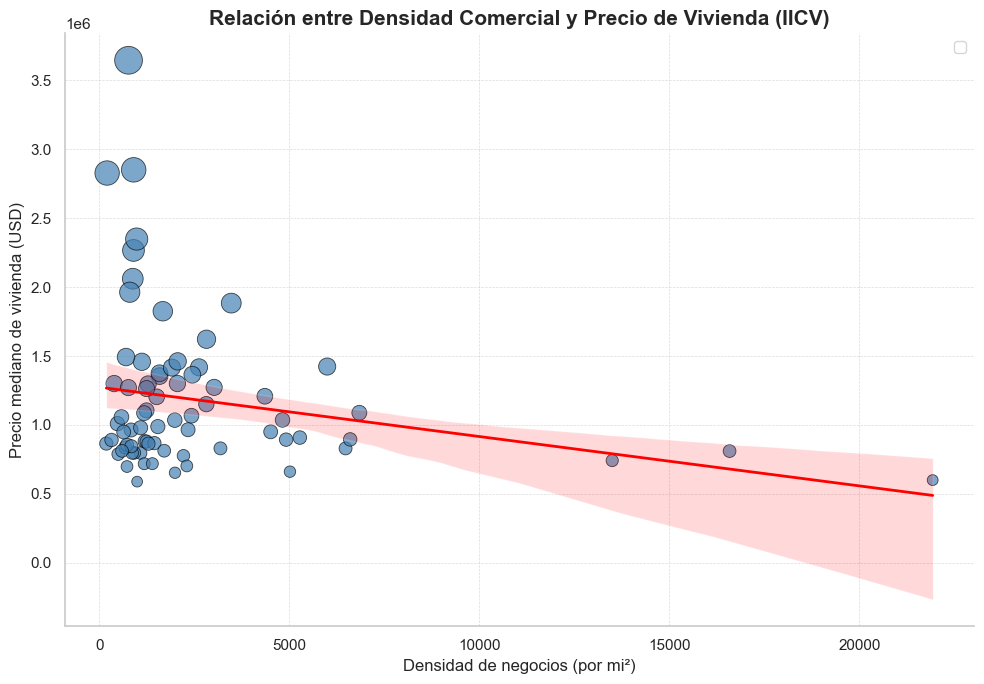

IICV (correlación): -0.227 — p-valor: 0.053


In [64]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_kpi, # DataFrame con densidad comercial y precios
    x='densidad_comercial',
    y='Price',
    color='steelblue', # Color de los puntos
    edgecolor='black', # Color del borde de los puntos
    linewidth=0.6, # Grosor del borde de los puntos
    alpha=0.7, # Transparencia de los puntos
    size=df_kpi['Price'] / 1000, # Tamaño de los puntos proporcional al precio
    sizes=(60, 400), # Tamaño de los puntos
    legend=False # Desactivar leyenda de tamaño
)
sns.regplot(
    data=df_kpi,
    x='densidad_comercial',
    y='Price',
    scatter=False, # No mostrar puntos de dispersión
    color='red', # Color de la línea de regresión
    line_kws={'linewidth': 2, 'label': 'Tendencia'}, # Personalización de la línea de regresión
    ci=95 # Intervalo de confianza del 95%
)
plt.title('Relación entre Densidad Comercial y Precio de Vivienda (IICV)', fontsize=15, weight='bold')
plt.xlabel('Densidad de negocios (por mi²)', fontsize=12)
plt.ylabel('Precio mediano de vivienda (USD)', fontsize=12)
plt.legend(loc='upper right', frameon=True)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
sns.despine()
plt.tight_layout()
plt.show()

print(f"IICV (correlación): {iicv_valor:.3f} — p-valor: {p_valor:.3f}")


La correlación obtenida entre la densidad comercial y el precio mediano de la vivienda en Los Ángeles fue:

> **`-0.227`** con un **p-valor de `0.053`**

Esto indica una **relación negativa débil** entre ambas variables.  
En otras palabras, **a mayor densidad de negocios, menor es el precio de la vivienda**, aunque esta relación **no es particularmente fuerte ni significativa a nivel estadístico**.



Entonces:
- En algunos vecindarios con **alta actividad comercial**, los precios de vivienda **no son necesariamente más altos**.
- Esto **contradice la idea común** de que un mayor actividad comercial siempre incrementa el valor residencial.
- Al menos en este caso, el comercio **no parece elevar de forma directa** el valor inmobiliario.  
  Puede haber otros factores más determinantes, como la seguridad.

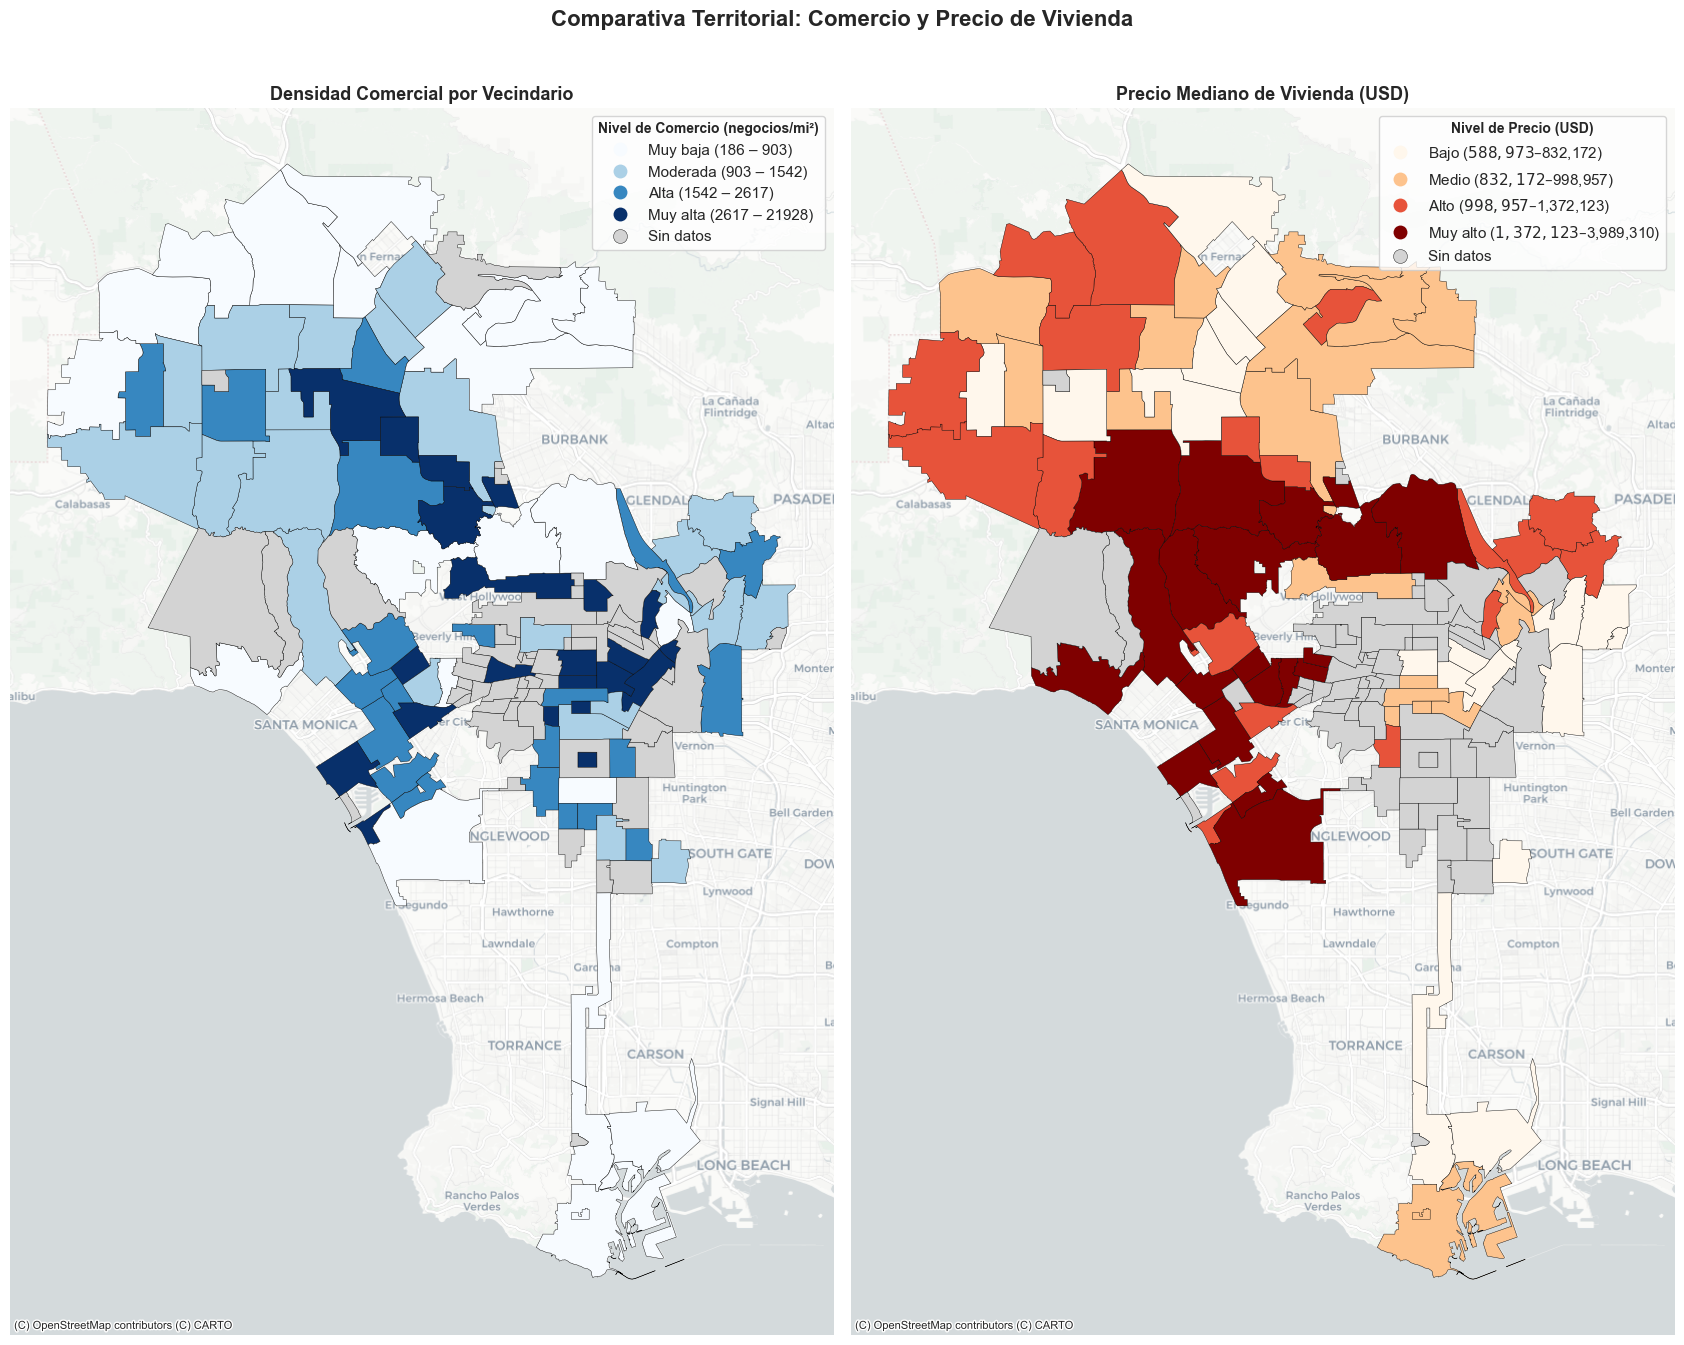

In [ ]:
# Crear GeoDataFrame base
map_gdf = neigh_gdf[['name', 'geometry']].copy()
map_gdf['neighborhood_clean'] = map_gdf['name'].str.lower().str.strip()

# Unir con densidad y precios
map_gdf = map_gdf.merge(
    densidad_df[['neighborhood_clean', 'densidad_comercial']],
    on='neighborhood_clean',
    how='left'
)
map_gdf = map_gdf.merge(
    ultimos_precios[['neighborhood_clean', 'Price']],
    on='neighborhood_clean',
    how='left'
)

# Re-proyección para fondo de mapa
map_gdf = map_gdf.to_crs(epsg=3857)

#
fig, ax = plt.subplots(1, 2, figsize=(17, 14))

# ------------------ Mapa 1: Densidad Comercial ------------------
map_gdf.plot(
    column='densidad_comercial',
    cmap='Blues',
    scheme='Quantiles',
    k=4,
    legend=True,
    edgecolor='black',
    linewidth=0.3,
    ax=ax[0],
    missing_kwds={'color': 'lightgrey', 'edgecolor': 'black', 'label': 'Sin datos'}
)
ctx.add_basemap(ax[0], source=ctx.providers.CartoDB.Positron)
ax[0].set_title("Densidad Comercial por Vecindario", fontsize=13, weight='bold')
ax[0].axis('off')

# Leyenda densidad
leg_dens = ax[0].get_legend()
if leg_dens:
    leg_dens.set_title("Nivel de Comercio (negocios/mi²)", prop={'size': 10, 'weight': 'bold'})
    etiquetas = ["Muy baja", "Moderada", "Alta", "Muy alta"]
    for i, text in enumerate(leg_dens.get_texts()):
        if "," in text.get_text():
            l, r = text.get_text().replace("(", "").replace("]", "").split(",")
            text.set_text(f"{etiquetas[i]} ({float(l):.0f} – {float(r):.0f})")
        elif "Sin datos" in text.get_text():
            text.set_text("Sin datos")

# ------------------ Mapa 2: Precio de Vivienda ------------------
map_gdf.plot(
    column='Price',
    cmap='OrRd',
    scheme='Quantiles',
    k=4,
    legend=True,
    edgecolor='black',
    linewidth=0.3,
    ax=ax[1],
    missing_kwds={'color': 'lightgrey', 'edgecolor': 'black', 'label': 'Sin datos'}
)
ctx.add_basemap(ax[1], source=ctx.providers.CartoDB.Positron)
ax[1].set_title("Precio Mediano de Vivienda (USD)", fontsize=13, weight='bold')
ax[1].axis('off')

# Leyenda precios
leg_precio = ax[1].get_legend()
if leg_precio:
    leg_precio.set_title("Nivel de Precio (USD)", prop={'size': 10, 'weight': 'bold'})
    etiquetas = ["Bajo", "Medio", "Alto", "Muy alto"]
    for i, text in enumerate(leg_precio.get_texts()):
        if "," in text.get_text():
            l, r = text.get_text().replace("(", "").replace("]", "").split(",")
            text.set_text(f"{etiquetas[i]} (${int(float(l)):,} – ${int(float(r)):,})")
        elif "Sin datos" in text.get_text():
            text.set_text("Sin datos")

# ------------------ Título General ------------------
plt.suptitle("Comparativa Territorial: Comercio y Precio de Vivienda", fontsize=16, weight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

- El primer mapa muestra la **concentración de negocios** por vecindario, categorizada desde *muy baja* hasta *muy alta*.

- El segundo mapa presenta la **variación de precios de vivienda** por zona.

- Al comparar ambos, es evidente que **las zonas con mayor densidad comercial no coinciden necesariamente con aquellas de mayor valor inmobiliario**.

### Desfase entre Comercio y Precio de Vivienda

Además del valor de correlación entre comercio y vivienda, analizamos el **desfase de rankings** entre ambos indicadores.

#### ¿Cómo se calcula?
1. Se asigna un **ranking descendente** (mayor = mejor) a cada vecindario según:
   - Densidad comercial
   - Precio mediano de vivienda
2. Se calcula la diferencia entre estos rankings:
   - Si el ranking comercial es mucho más alto que el de precios → "Comercio mayor que precio"
   - Si están similares → "Balanceado"
   - Si el precio es mucho mayor que el comercio → "Precio mayor que comercio"

#### ¿Qué aporta este análisis?
- Identifica **zonas desequilibradas**, donde:
  - Hay mucha actividad comercial pero precios bajos (posible subvalorización o rezago residencial)
  - Hay precios altos pero poca actividad comercial (zonas residenciales de lujo, poco dinámicas)

El **mapa categorizado** permite visualizar rápidamente **qué tipo de desfase ocurre en cada vecindario**, ayudando a **guiar políticas urbanas, estrategias de inversión o priorización territorial**.


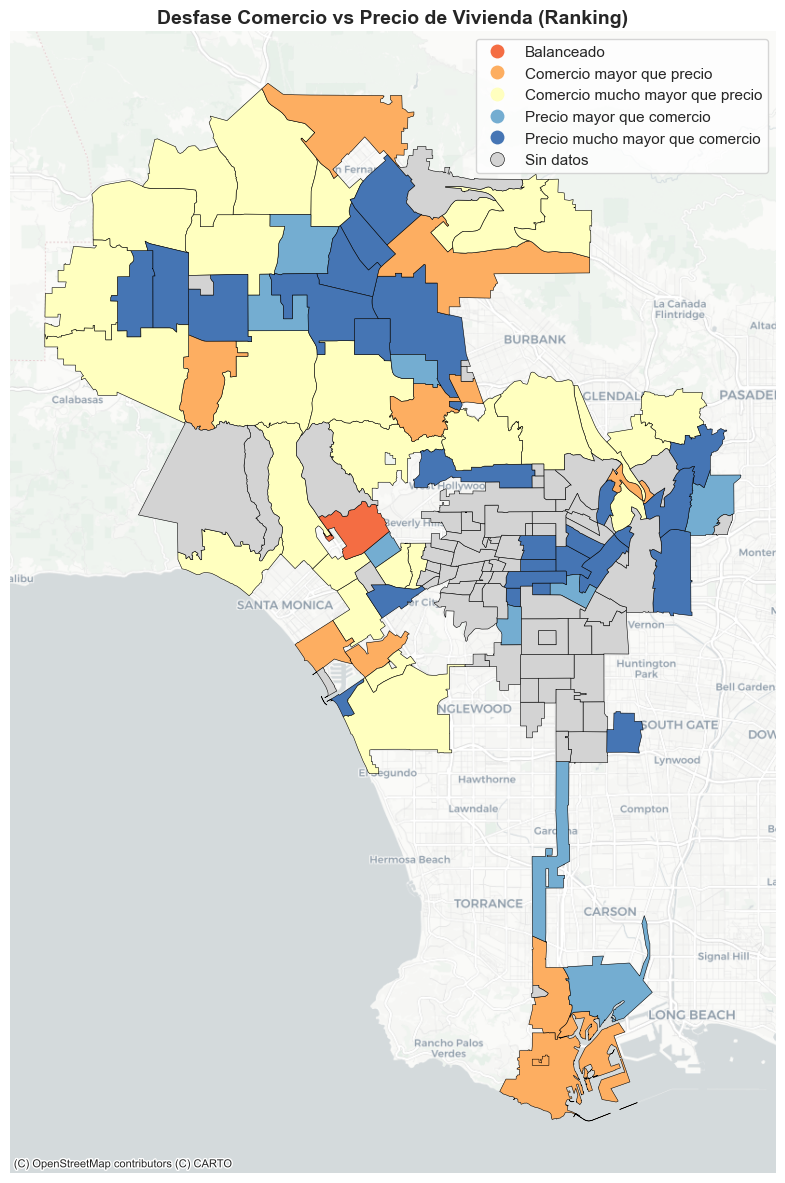

In [ ]:
map_gdf_clean = map_gdf.copy()
map_gdf_valid = map_gdf_clean.dropna(subset=['densidad_comercial', 'Price']).copy()

# Calcular rankings (mayor valor = mejor ranking)
map_gdf_valid['rank_densidad'] = map_gdf_valid['densidad_comercial'].rank(ascending=False)
map_gdf_valid['rank_precio'] = map_gdf_valid['Price'].rank(ascending=False)

# Calcular diferencia de ranking
map_gdf_valid['diff_rank'] = map_gdf_valid['rank_densidad'] - map_gdf_valid['rank_precio']

# Clasificación cualitativa
def clasificar_diferencia(x):
    if pd.isna(x):
        return "Sin datos"
    elif x >= 10:
        return "Comercio mucho mayor que precio"
    elif x >= 3:
        return "Comercio mayor que precio"
    elif x > -3:
        return "Balanceado"
    elif x > -10:
        return "Precio mayor que comercio"
    else:
        return "Precio mucho mayor que comercio"

map_gdf_valid['diff_cat'] = map_gdf_valid['diff_rank'].apply(clasificar_diferencia)

# Volver a unir al GeoDataFrame original para conservar sin datos
map_gdf_clean = map_gdf_clean.merge(
    map_gdf_valid[['neighborhood_clean', 'diff_cat']],
    on='neighborhood_clean',
    how='left'
)

# Reproyectar
map_gdf_clean = map_gdf_clean.to_crs(epsg=3857)

# Definir paleta de colores
colores = {
    "Comercio mucho mayor que precio": "#f46d43",
    "Comercio mayor que precio": "#fdae61",
    "Balanceado": "#ffffbf",
    "Precio mayor que comercio": "#74add1",
    "Precio mucho mayor que comercio": "#4575b4",
    "Sin datos": "lightgrey"
}

# Mapa
fig, ax = plt.subplots(figsize=(10, 12))
map_gdf_clean.plot(
    column='diff_cat',
    ax=ax,
    legend=True,
    edgecolor='black',
    linewidth=0.4,
    cmap=plt.matplotlib.colors.ListedColormap([colores[c] for c in colores if c != "Sin datos"]),
    categorical=True,
    missing_kwds={
        'color': colores["Sin datos"],
        'edgecolor': 'black',
        'label': 'Sin datos'
    }
)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title("Desfase Comercio vs Precio de Vivienda (Ranking)", fontsize=14, weight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()

Este mapa compara el nivel de comercio y el precio de vivienda en cada vecindario, mostrando si están equilibrados o si hay un desfase entre ambos.

`ROJO` - Mucho comercio, bajo precio: Zonas con alta actividad comercial, pero donde las casas no son caras. Puede ser una oportunidad de desarrollo o un síntoma de rezago habitacional.

`NARANJA` - Más comercio que precio: El comercio está por encima del valor de las viviendas, aunque no tanto. Posible potencial de crecimiento inmobiliario.

`AMARILLO` - Balanceado: Comercio y precios van de la mano. Nada inusual.

`AZUL-CLARO` - Más precio que comercio: Las casas valen más de lo que indicaría el nivel de comercios. Puede ser por prestigio, ubicación o atributos no comerciales.

`AZUL-MARINO`- Precio mucho mayor que comercio: Zonas con precios altos y poco comercio. Probablemente residenciales exclusivas.

`GRIS` - Sin datos: Áreas con información insuficiente.

## KPI 3: Índice de Sensibilidad del Valor Inmobiliario a la Seguridad (ISV)

### Objetivo

Este indicador busca evaluar **cómo influye el cambio en la criminalidad sobre el cambio en el precio de la vivienda**. Nos permite analizar si los incrementos o reducciones en la inseguridad se reflejan directamente en el comportamiento del mercado inmobiliario a nivel vecindario.

---

### Fórmulas

**Cambio porcentual de criminalidad por periodo** (mes o año):

$$ d_c = \frac{C_t}{C_{t-1}} - 1 $$

Donde:

- \( $C_t$ \): Número total de crímenes en el periodo \( $t$ \)
- \( $C_{t-1}$ \): Número total de crímenes en el periodo anterior

---

**Cambio porcentual del precio mediano de la vivienda**:

$$ d_p = \frac{P_t}{P_{t-1}} - 1 $$

Donde:

- \( $P_t$ \): Precio mediano de la vivienda en el periodo \( $t$ \)
- \( $P_{t-1}$ \): Precio mediano del periodo anterior

---

### Índice de Sensibilidad del Valor Inmobiliario a la Seguridad:

Se define como la **correlación entre el cambio porcentual de criminalidad y el cambio porcentual del precio inmobiliario**, por vecindario:

$$ \text{ISV} = \text{Corr}(d_c, d_p) $$

---

### Lógica de implementación

1. Agrupar el dataset de **crimen** por `Vecindario_Oficial` y `Mes/Año` para obtener \( $C_t$ \).
2. Calcular el **cambio porcentual mensual** en crímenes \( d_c \) por vecindario.
3. Agrupar el dataset de **vivienda** (`inmu`) por `RegionName` y `date` para obtener \( $P_t$ \).
4. Calcular el **cambio porcentual mensual** del precio \( d_p \) por vecindario.
5. Unir ambos datasets por `vecindario` y `fecha`.
6. Calcular la **correlación** entre las columnas `d_c` y `d_p` para cada vecindario.
7. Analizar si existe una relación significativa (positiva o negativa) entre los cambios.

---

### Interpretación

- Un valor **positivo** del ISV sugiere que **más crimen = precios más altos** (inusual, pero posible en zonas gentrificadas).
- Un valor **negativo** del ISV sugiere que **más crimen = precios más bajos**, lo cual es común en muchas áreas.
- Un valor cercano a **cero** indica **falta de relación directa** entre las variables en ese vecindario.



In [67]:
# ============================
# KPI 3: Índice de Seguridad Comercial (ISV)
# ============================

# --- 1. Crimen mensual por vecindario ---
# Extraer mes como string para merge
crime['mes'] = crime['DATE OCC'].dt.to_period('M').astype(str)

# Agrupar por vecindario y mes: total de crímenes
crimen_mensual = (
    crime.groupby(['neighborhood_clean', 'mes'])
    .size()
    .reset_index(name='total_crimenes')
)

# Calcular variación porcentual mensual del crimen
crimen_mensual['variacion_crimen'] = (
    crimen_mensual
    .groupby('neighborhood_clean')['total_crimenes']
    .pct_change()
)

# --- 2. Precio mensual por vecindario ---
inmu['mes'] = inmu['date'].dt.to_period('M').astype(str)

precio_mensual = (
    inmu.groupby(['neighborhood_clean', 'mes'])['Price']
    .median()
    .reset_index(name='precio_median_mensual')
)

# Calcular variación porcentual mensual del precio
precio_mensual['variacion_precio'] = (
    precio_mensual
    .groupby('neighborhood_clean')['precio_median_mensual']
    .pct_change()
)

# --- 3. Unir datasets ---
isv_df = crimen_mensual.merge(
    precio_mensual,
    on=['neighborhood_clean', 'mes'],
    how='inner'
).dropna(subset=['variacion_crimen', 'variacion_precio'])

# --- 4. ISV global ---
from scipy.stats import pearsonr

isv_valor, p_valor = pearsonr(isv_df['variacion_crimen'], isv_df['variacion_precio'])
print(f"ISV global: {isv_valor:.3f} — p-valor: {p_valor:.3f}")

# --- 5. ISV por vecindario ---
isv_por_vecindario = (
    isv_df.groupby('neighborhood_clean')[['variacion_crimen', 'variacion_precio']]
    .corr()
    .iloc[0::2, -1]
    .reset_index()
    .rename(columns={'level_1': 'tipo', 'variacion_precio': 'ISV'})
    .query("tipo == 'variacion_crimen'")
)

print(isv_por_vecindario.head(10))


ISV global: 0.073 — p-valor: 0.000
  neighborhood_clean              tipo       ISV
0    adams-normandie  variacion_crimen  0.075070
1             arleta  variacion_crimen  0.114216
2  arlington heights  variacion_crimen  0.155105
3    atwater village  variacion_crimen  0.122764
4      beverly crest  variacion_crimen  0.169731
5        beverlywood  variacion_crimen -0.076720
6      boyle heights  variacion_crimen  0.053773
7          brentwood  variacion_crimen  0.152381
8        canoga park  variacion_crimen  0.104300
9       century city  variacion_crimen  0.023858


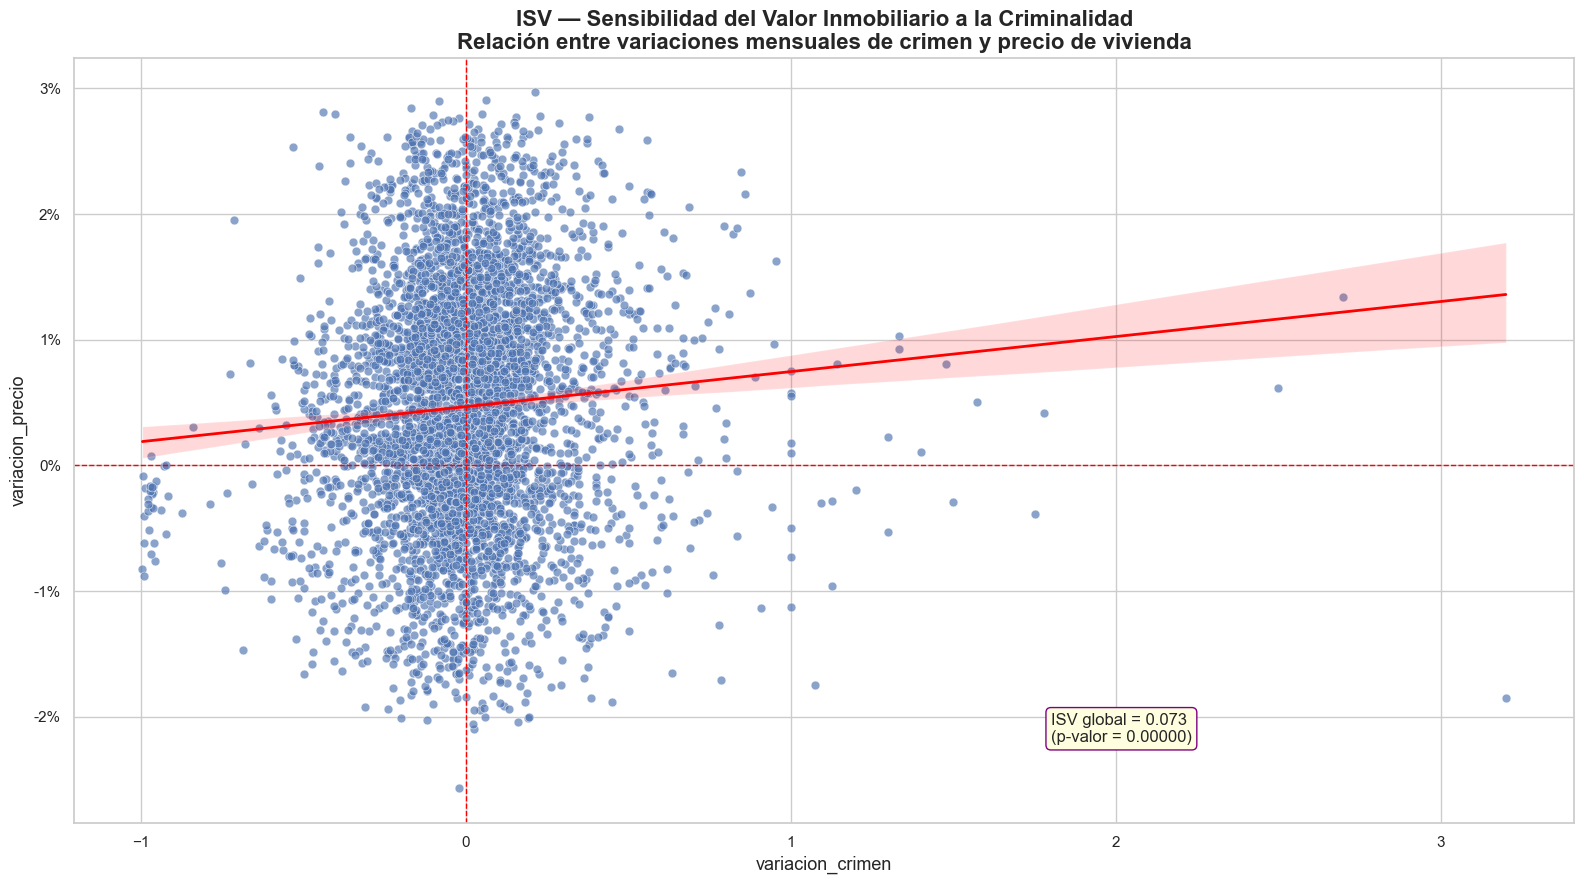

In [68]:
# Gráfico principal
plt.figure(figsize=(16, 9))
sns.set(style="whitegrid")

# Scatterplot
sns.scatterplot(
    data=isv_df,
    x='variacion_crimen',
    y='variacion_precio',
    alpha=0.65,
    s=40,
    edgecolor='w',
    linewidth=0.5
)

# Títulos y ejes
plt.title('ISV — Sensibilidad del Valor Inmobiliario a la Criminalidad\nRelación entre variaciones mensuales de crimen y precio de vivienda', fontsize=16, weight='bold')
plt.xlabel('Variación mensual de criminalidad (%)', fontsize=13)
plt.ylabel('Variación mensual del precio de vivienda (%)', fontsize=13)

# Líneas guía
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.axvline(0, color='red', linestyle='--', linewidth=1)

sns.regplot(
    data=isv_df,
    x='variacion_crimen',
    y='variacion_precio',
    scatter=False, # No mostrar puntos de dispersión
    color='red',
    line_kws={'linewidth': 2} # Personalización de la línea de regresión
)

# Anotación del valor del ISV Global
plt.text(
    x=1.8, y=-0.022, 
    s=f"ISV global = {isv_valor:.3f}\n(p-valor = {p_valor:.5f})",
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", edgecolor="purple")
)

from matplotlib.ticker import FuncFormatter
#plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0%}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))


plt.tight_layout()
plt.show()

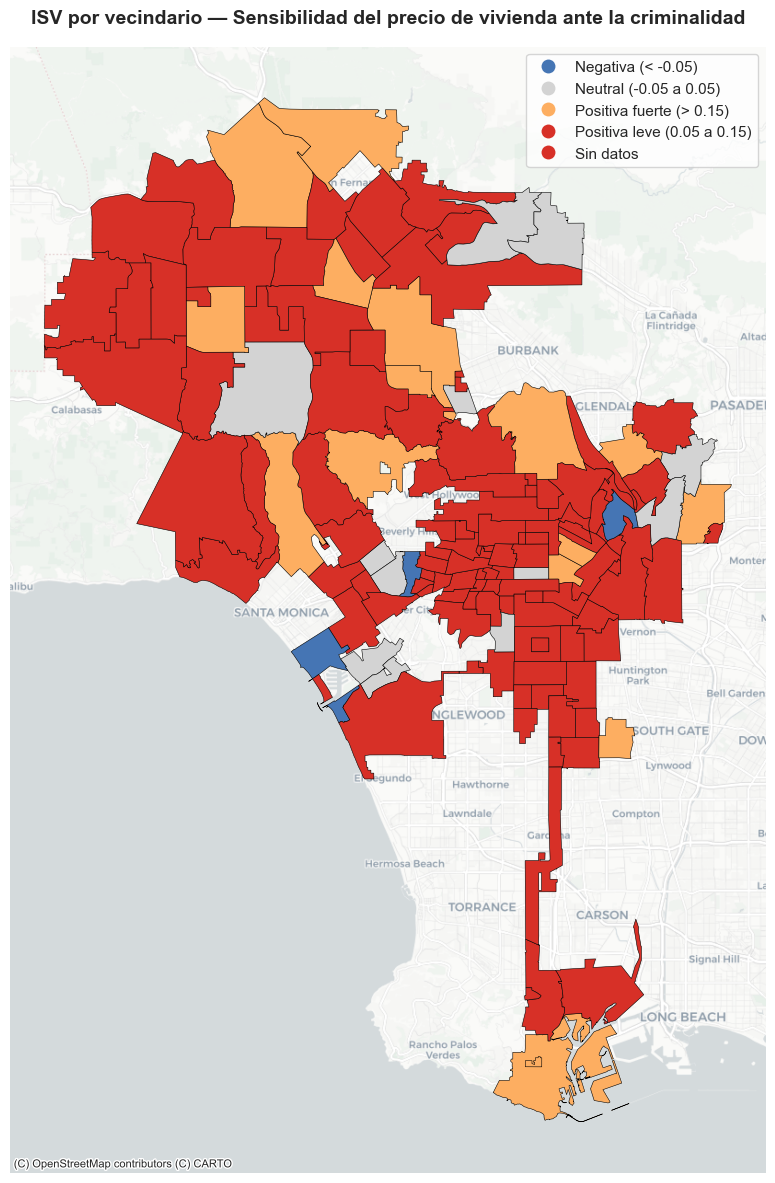

In [69]:
# --- MAPA ISV POR VECINDARIO ---

# 1. Preparar base del mapa con geometría y vecindarios normalizados
map_isv = neigh_gdf[['name', 'geometry']].copy()
map_isv.rename(columns={'name': 'Neighborhood'}, inplace=True)
map_isv['neighborhood_clean'] = map_isv['Neighborhood'].str.lower().str.strip()

# 2. Unir con resultados de ISV por vecindario
map_isv = map_isv.merge(
    isv_por_vecindario[['neighborhood_clean', 'ISV']],
    on='neighborhood_clean',
    how='left'
)

# 3. Clasificar ISV en categorías interpretables
def clasificar_isv(valor):
    if pd.isna(valor):
        return "Sin datos"
    elif valor < -0.05:
        return "Negativa (< -0.05)"
    elif valor < 0.05:
        return "Neutral (-0.05 a 0.05)"
    elif valor < 0.15:
        return "Positiva leve (0.05 a 0.15)"
    else:
        return "Positiva fuerte (> 0.15)"

map_isv['categoria_isv'] = map_isv['ISV'].apply(clasificar_isv)

# 4. Reproyectar para mapa base
map_isv = map_isv.to_crs(epsg=3857)

# 5. Definir colores personalizados
colores_isv = {
    "Negativa (< -0.05)": "#4575b4",         # Azul fuerte
    "Neutral (-0.05 a 0.05)": "#d3d3d3",      # Gris claro
    "Positiva leve (0.05 a 0.15)": "#fdae61", # Naranja suave
    "Positiva fuerte (> 0.15)": "#d73027",    # Rojo fuerte
    "Sin datos": "lightgrey"
}

# 6. Crear mapa
fig, ax = plt.subplots(figsize=(10, 12))
map_isv.plot(
    column='categoria_isv',
    cmap=plt.matplotlib.colors.ListedColormap([colores_isv[c] for c in colores_isv if c != "Sin datos"]),
    legend=True,
    categorical=True,
    edgecolor='black',
    linewidth=0.4,
    ax=ax,
    missing_kwds={
        'color': colores_isv["Sin datos"],
        'edgecolor': 'black',
        'label': 'Sin datos'
    }
)

# 7. Añadir fondo de mapa y estética
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title("ISV por vecindario — Sensibilidad del precio de vivienda ante la criminalidad", fontsize=14, weight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()


### ISV por vecindario — Sensibilidad del precio de vivienda ante la criminalidad

Este mapa representa la relación entre las variaciones mensuales de criminalidad y los cambios en el precio de la vivienda por vecindario en Los Ángeles. Se usó el Índice de Sensibilidad del Valor Inmobiliario a la Criminalidad (ISV) para clasificar los vecindarios en función de dicha relación.

- **🔵 ISV negativo:** A mayor crimen, menor precio de vivienda.
- **🔷 ISV neutro:** Sin relación significativa.
- **🟧 ISV positivo leve:** Ligera correlación positiva.
- **🔴 ISV positivo fuerte:** A mayor crimen, también sube el precio (inusual, pero posible en zonas en transformación).
- **⚪ Sin datos:** Información insuficiente para el cálculo.

Este análisis permite entender qué zonas podrían ser más sensibles a los cambios en seguridad desde una perspectiva inmobiliaria.


In [70]:
# --- Mapa interactivo del ISV por vecindario (Folium) ---

# Asegurar que el GeoDataFrame esté en el sistema de coordenadas EPSG:4326 (requerido por folium)
map_isv = map_isv.to_crs(epsg=4326)

# Crear mapa base centrado en Los Ángeles
m = folium.Map(location=[34.05, -118.25], zoom_start=10, tiles="CartoDB positron")

# Rango del ISV
min_isv = map_isv['ISV'].min()
max_isv = map_isv['ISV'].max()

# Colormap personalizado
colormap = cm.LinearColormap(
    colors=['blue', 'white', 'red'],
    vmin=min_isv,
    vmax=max_isv
)
colormap.caption = "ISV — Sensibilidad del valor de vivienda a la criminalidad"

# Capa de polígonos
folium.GeoJson(
    data=json.loads(map_isv.to_json()),
    style_function=lambda feature: {
        'fillColor': colormap(feature['properties']['ISV']) if feature['properties']['ISV'] is not None else 'lightgray',
        'color': 'white',
        'weight': 0.5,
        'fillOpacity': 0.7
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['Neighborhood', 'ISV'],
        aliases=['Vecindario:', 'ISV:'],
        localize=True
    )
).add_to(m)

# Añadir leyenda al mapa
colormap.add_to(m)

# Guardar archivo HTML
m.save('../data/ISV_mapa_interactivo_kpi3.html')

# Mostrar en notebook (si se desea visualizar directamente)
m


## KPI 4 — Índice de la Influencia de la Madurez Comercial para la Estabilidad Habitacional (IMCEH)

IMCEH (correlación): 0.315 — p-valor: 0.004


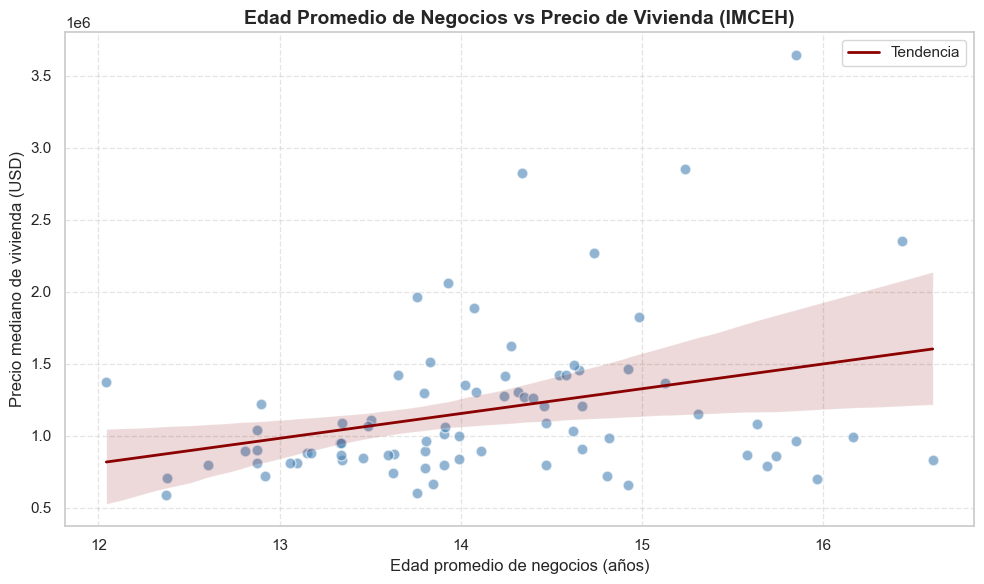

In [71]:
# ===========================
# KPI 4 — IMCEH: Influencia de la Madurez Comercial en la Estabilidad Habitacional
# ===========================

# 1. Filtrar negocios activos (sin fecha de cierre)
negocios_activos = business[business['LOCATION END DATE'].isna()].copy()

# 2. Calcular edad en años desde su apertura hasta hoy
hoy = pd.to_datetime("today")
negocios_activos['edad_negocio'] = (hoy - negocios_activos['LOCATION START DATE']).dt.days / 365

# 3. Edad promedio de negocios por vecindario
edad_promedio = (
    negocios_activos
    .groupby('neighborhood_clean')['edad_negocio']
    .mean()
    .reset_index()
    .rename(columns={'edad_negocio': 'edad_promedio_negocios'})
)

# 4. Precio de vivienda más reciente por vecindario (ya está limpio)
precio_actual = (
    inmu.sort_values('date')
    .groupby('neighborhood_clean')
    .tail(1)[['neighborhood_clean', 'Price']]
)

# 5. Unir ambas tablas
imceh_df = edad_promedio.merge(precio_actual, on='neighborhood_clean', how='inner')

# 6. Calcular correlación
imceh_valor, p_valor = pearsonr(imceh_df['edad_promedio_negocios'], imceh_df['Price'])
print(f"IMCEH (correlación): {imceh_valor:.3f} — p-valor: {p_valor:.3f}")

# 7. Gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.regplot(
    data=imceh_df,
    x='edad_promedio_negocios',
    y='Price',
    scatter_kws={'alpha': 0.6, 'color': 'steelblue', 's': 60, 'edgecolor': 'white'},
    line_kws={'color': 'darkred', 'linewidth': 2, 'label': 'Tendencia'}
)
plt.title('Edad Promedio de Negocios vs Precio de Vivienda (IMCEH)', fontsize=14, weight='bold')
plt.xlabel('Edad promedio de negocios (años)', fontsize=12)
plt.ylabel('Precio mediano de vivienda (USD)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

El gráfico muestra una ligera **tendencia positiva** entre la **edad promedio de los negocios** y el **precio actual de la vivienda**. Nos puede indicar que, en algunos vecindarios de Los Ángeles, una **mayor madurez comercial** podría estar asociada a **mayor estabilidad habitacional**.

El valor de correlación obtenido (IMCEH) fue **positivo**, lo cual respalda la hipótesis de que los barrios con negocios más antiguos —posiblemente consolidados, estables o con trayectoria— tienden a presentar **precios de vivienda más altos**.

Zonas con tejido comercial maduro podrían transmitir confianza a residentes y compradores, lo cual se refleja en el mercado inmobiliario. Sin embargo, esta relación **no es fuerte**, por lo que podríamos considerarse otras variables para entender completamente el fenómeno.

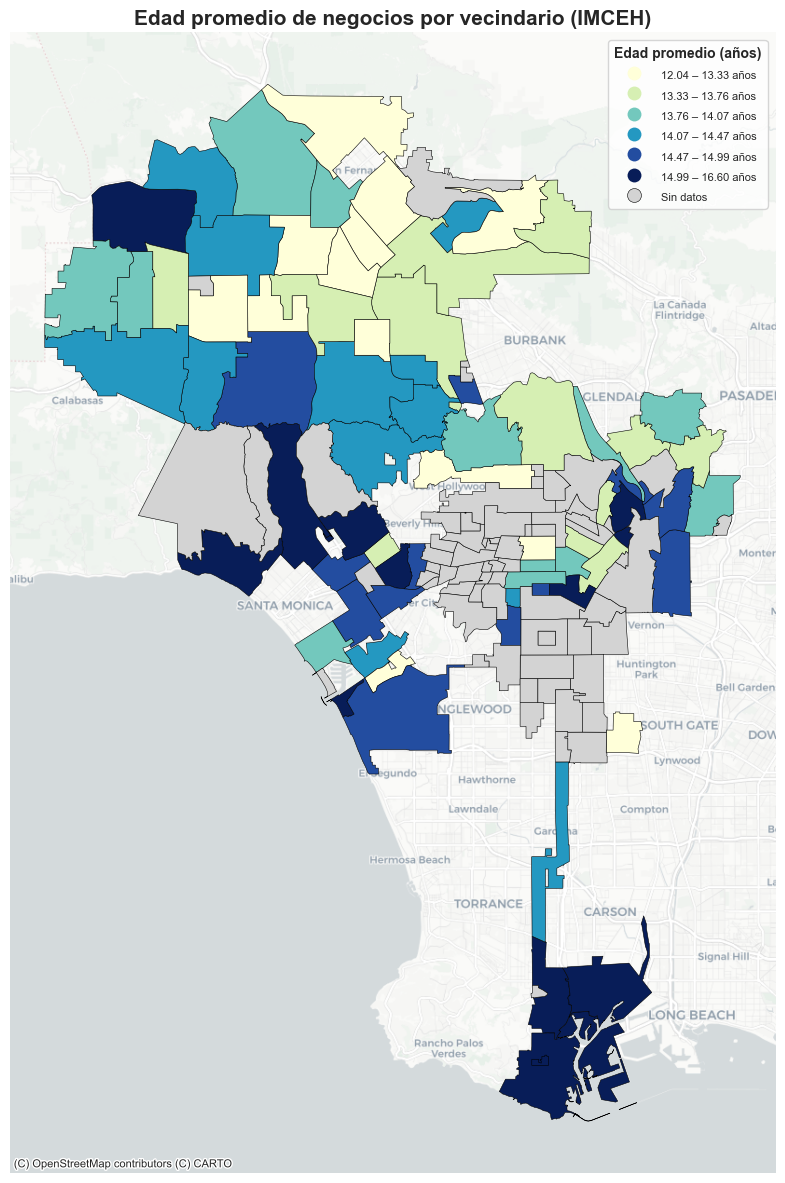

In [72]:
# ===========================
# Mapa — Edad Promedio de Negocios (IMCEH)
# ===========================

# 1. Leer geometría desde GeoJSON oficial
vecindarios = gpd.read_file(geojson_url)

# 2. Normalizar nombres
vecindarios['Neighborhood'] = vecindarios['name']
vecindarios['neighborhood_clean'] = vecindarios['Neighborhood'].str.lower().str.strip()

# Si ya tienes `vecindarios` con 'neighborhood_clean', no es necesario volver a cargar el geojson
mapa = vecindarios.merge(
    imceh_df[['neighborhood_clean', 'edad_promedio_negocios']],
    on='neighborhood_clean',
    how='left'
).to_crs(epsg=3857)


# Crear figura
fig, ax = plt.subplots(figsize=(10, 12))
mapa.plot(
    column='edad_promedio_negocios',
    cmap='YlGnBu',
    scheme='Quantiles',
    k=6,
    legend=True,
    edgecolor='black',
    linewidth=0.4,
    missing_kwds={
        'color': 'lightgrey',
        'edgecolor': 'black',
        'label': 'Sin datos'
    },
    ax=ax
)

# Estilizar leyenda
leg = ax.get_legend()
if leg:
    leg.set_title("Edad promedio (años)", prop={'size': 10, 'weight': 'bold'})
    for text in leg.get_texts():
        txt = text.get_text()
        if "," in txt:
            l, r = txt.replace("(", "").replace("]", "").split(",")
            text.set_text(f"{float(l):.2f} – {float(r):.2f} años")
        text.set_fontsize(8)

# Fondo y formato
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title("Edad promedio de negocios por vecindario (IMCEH)", fontsize=15, weight='bold')
ax.axis("off")
plt.tight_layout()

# Guardar y mostrar
plt.savefig("../data/imceh_map_kpi4.png", dpi=300, bbox_inches='tight')
plt.show()


### Mapa — Edad Promedio de Negocios por Vecindario (IMCEH)

Este mapa muestra la edad promedio de los negocios **activos** en cada vecindario de Los Ángeles. La escala de colores cuantílica permite distinguir de forma clara las zonas con mayor o menor madurez comercial:

- **Azul oscuro**: Vecindarios con negocios que tienen entre **15 y 16 años** de antigüedad. Estos lugares podrían representar áreas consolidadas, estables y posiblemente atractivas para residentes.
- **Amarillo claro / Verde**: Vecindarios con negocios relativamente más recientes (entre **12 y 13 años** de antigüedad). Estas zonas pueden estar en crecimiento, transformación o recuperación económica.
- **Gris claro**: Zonas sin datos disponibles suficientes para estimar la madurez comercial.

### Observación

La madurez comercial no está distribuida de forma uniforme. Algunas regiones costeras y del suroeste muestran negocios más antiguos, lo que puede reflejar estabilidad económica a largo plazo. En contraste, algunas zonas del centro y este presentan menor antigüedad, lo que podría indicar renovación o dinamismo reciente.

Este mapa ayuda a **visualizar cómo la trayectoria comercial podría estar relacionada con el mercado inmobiliario**, como lo sugiere la correlación calculada en el IMCEH.


## KPI 5 — Índice de Riesgo Comercial (IRC)

### Objetivo

Este indicador busca evaluar **qué tan expuestos están los negocios activos de un vecindario a la criminalidad**. La hipótesis es que un entorno con mayor criminalidad por establecimiento comercial podría afectar el dinamismo económico, la inversión, y en última instancia, el valor inmobiliario de la zona.

---

### Fórmula

El Índice de Riesgo Comercial se define como:

$$
IRC = \frac{Crímenes\ totales\ en\ el\ vecindario}{Número\ de\ negocios\ activos}
$$

Donde:

- \( IRC \): Índice de Riesgo Comercial del vecindario.
- **Crímenes totales**: Total de delitos registrados en el vecindario (agregados históricamente).
- **Negocios activos**: Número de negocios sin fecha de cierre (`LOCATION END DATE` vacía).

---

### Interpretación

- Un **IRC alto** indica mayor exposición de los negocios al crimen. Puede desalentar nuevas aperturas o inversiones.
- Un **IRC bajo** sugiere un entorno relativamente más seguro para la actividad comercial.

---

### Aplicación

Este índice puede:
- Mapearse para detectar **zonas de riesgo comercial**.
- Cruzarse con la **edad promedio de negocios** (¿en zonas peligrosas los negocios duran menos?).
- Analizar su relación con el **precio de la vivienda** (¿las zonas comerciales más seguras valen más?).


In [ ]:
# ===========================
# KPI 5 — Índice de Riesgo Comercial (IRC)
# ===========================

# 1. Total de crímenes por vecindario
crimen_por_vec = crime.groupby('neighborhood_clean').size().reset_index(name='total_crimenes')

# 2. Filtrar negocios activos (sin fecha de cierre)
negocios_activos = business[business['LOCATION END DATE'].isna()].copy()

# 3. Contar negocios activos por vecindario
negocios_activos_por_vec = (
    negocios_activos
    .groupby('neighborhood_clean')
    .size()
    .reset_index(name='negocios_activos')
)

# 4. Unir crímenes + negocios activos
irc_df = crimen_por_vec.merge(negocios_activos_por_vec, on='neighborhood_clean', how='inner')

# 5. Calcular IRC
irc_df['IRC'] = irc_df['total_crimenes'] / irc_df['negocios_activos']

# Ver ejemplo
print(irc_df.head())


       neighborhood_clean  total_crimenes  negocios_activos       IRC
0         adams-normandie            3808              2322  1.639966
1                  arleta            3981              3926  1.014009
2       arlington heights            5245              4116  1.274295
3         atwater village            2502              4488  0.557487
4  baldwin hills/crenshaw           10013              4448  2.251124


In [78]:
# ===========================
# KPI 5 — Índice de Riesgo Comercial (IRC)
# ===========================

# 1. Filtrar negocios activos
negocios_activos = business[business['LOCATION END DATE'].isna()].copy()

# 2. Contar negocios activos por vecindario
negocios_por_vecindario = (
    negocios_activos
    .groupby('neighborhood_clean')
    .size()
    .reset_index(name='negocios_activos')
)

# 3. Contar crímenes por vecindario
crime['neighborhood_clean'] = crime['Neighborhood'].str.lower().str.strip()
crimen_por_vecindario = (
    crime.groupby('neighborhood_clean')
    .size()
    .reset_index(name='total_crimenes')
)

# 4. Unir ambos conteos
irc_df = negocios_por_vecindario.merge(
    crimen_por_vecindario, on='neighborhood_clean', how='inner'
)

# 5. Calcular índice IRC
irc_df['IRC'] = irc_df['total_crimenes'] / irc_df['negocios_activos']

# 6. Vista previa
print(irc_df.sort_values('IRC', ascending=False).head(10))


       neighborhood_clean  negocios_activos  total_crimenes       IRC
38          griffith park               150            1439  9.593333
40             hansen dam                60             319  5.316667
17   chatsworth reservoir                10              51  5.100000
103                 watts              2354           10741  4.562872
37          green meadows              2964           13008  4.388664
94        university park              2302            9387  4.077758
11    broadway-manchester              2508           10175  4.057018
101         vermont vista              2420            9408  3.887603
102       vermont-slauson              3162           11700  3.700190
99         vermont knolls              2468            9052  3.667747


In [88]:
# 1. Agrupar crimen por vecindario limpio
crime['neighborhood_clean'] = crime['Neighborhood'].str.lower().str.strip()
crimen_por_vecindario = (
    crime.groupby('neighborhood_clean')
    .size()
    .reset_index(name='total_crimenes')
)

# 2. Filtrar negocios activos y contar por vecindario
negocios_activos = business[business['LOCATION END DATE'].isna()].copy()
negocios_por_vecindario = (
    negocios_activos.groupby('neighborhood_clean')
    .size()
    .reset_index(name='num_negocios_activos')
)

# 3. Calcular IRC
irc_df = crimen_por_vecindario.merge(negocios_por_vecindario, on='neighborhood_clean', how='inner')
irc_df['IRC'] = irc_df['total_crimenes'] / irc_df['num_negocios_activos']

print(irc_df.sort_values('IRC', ascending=False).head(10))


       neighborhood_clean  total_crimenes  num_negocios_activos       IRC
38          griffith park            1439                   150  9.593333
40             hansen dam             319                    60  5.316667
17   chatsworth reservoir              51                    10  5.100000
103                 watts           10741                  2354  4.562872
37          green meadows           13008                  2964  4.388664
94        university park            9387                  2302  4.077758
11    broadway-manchester           10175                  2508  4.057018
101         vermont vista            9408                  2420  3.887603
102       vermont-slauson           11700                  3162  3.700190
99         vermont knolls            9052                  2468  3.667747


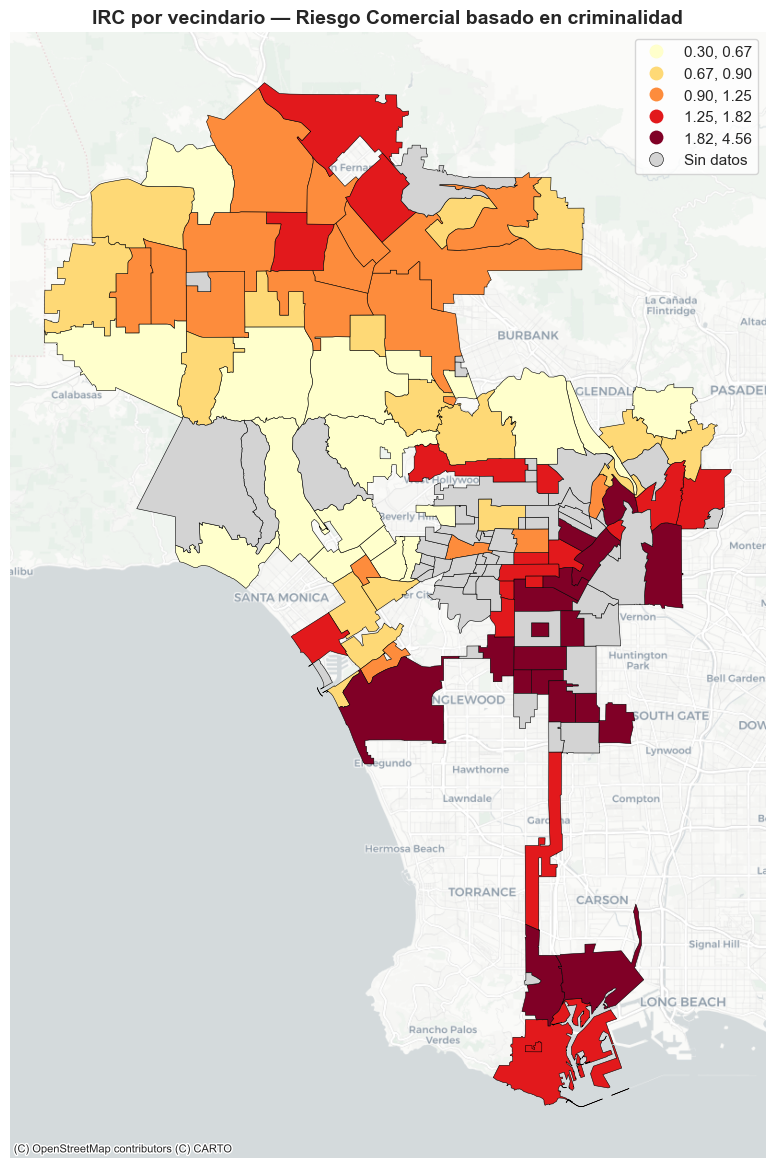

In [ ]:
# 4. Leer geometría
geojson_url = "https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/eva_pereira_lahub_BA_24d4f6a092ee4506/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"
neigh_gdf = gpd.read_file(geojson_url)
neigh_gdf['neighborhood_clean'] = neigh_gdf['name'].str.lower().str.strip()

# 5. Unir geometría con IRC
mapa_irc = neigh_gdf.merge(irc_df[['neighborhood_clean', 'IRC']], on='neighborhood_clean', how='left')
mapa_irc = mapa_irc.to_crs(epsg=3857)

### Visualización del IRC por vecindario

fig, ax = plt.subplots(figsize=(10, 12))

mapa_irc.plot(
    column='IRC',
    cmap='YlOrRd',
    scheme='Quantiles',
    k=5,
    edgecolor='black',
    linewidth=0.4,
    legend=True,
    missing_kwds={
        'color': 'lightgrey',
        'edgecolor': 'black',
        'label': 'Sin datos'
    },
    ax=ax
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title("IRC por vecindario — Riesgo Comercial basado en criminalidad", fontsize=14, weight='bold')
ax.axis("off")

# Ajuste visual
plt.tight_layout()
plt.show()




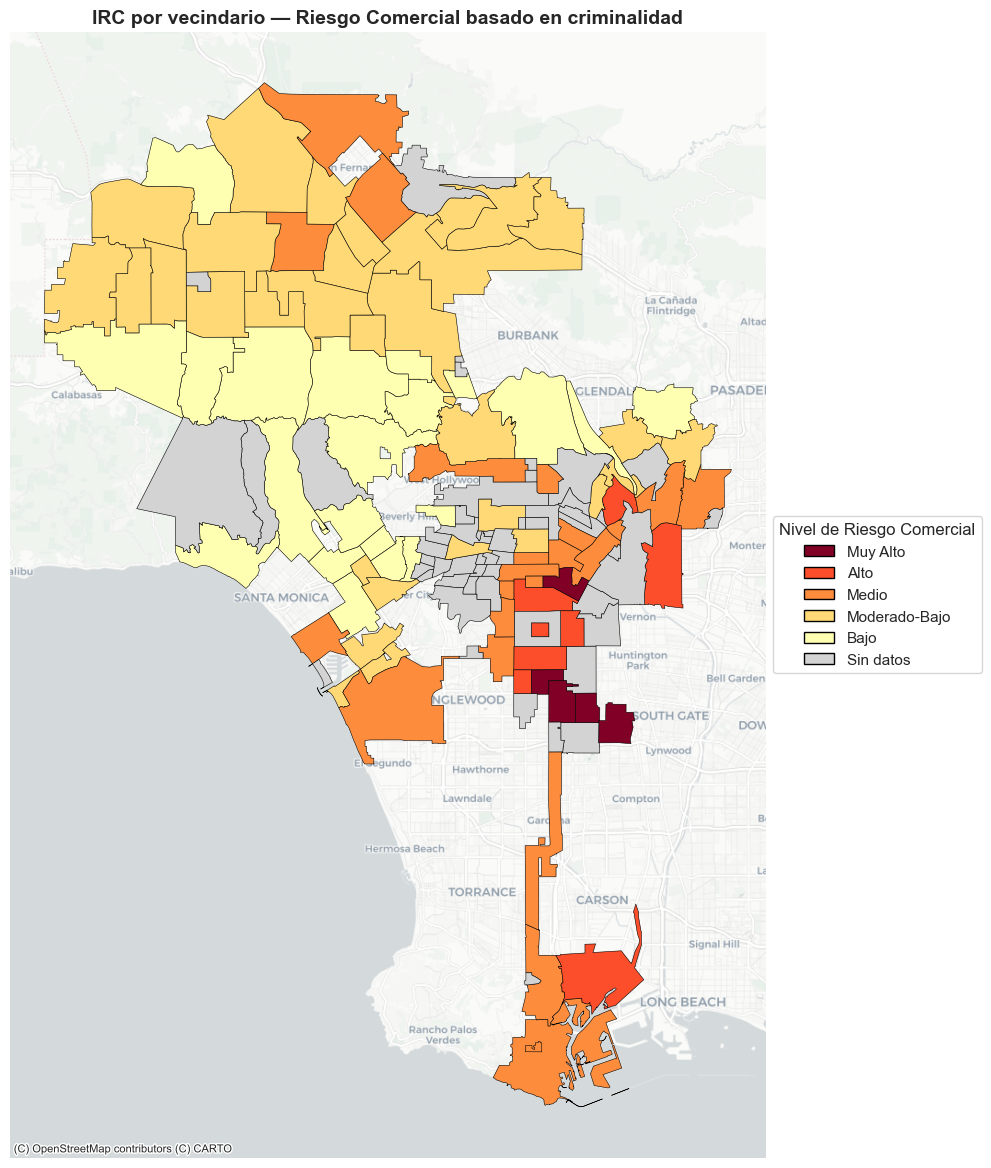

In [ ]:
# ===========================
# KPI 5 — Índice de Riesgo Comercial (IRC)
# ===========================

# 1. Calcular total de crímenes por vecindario
crime['neighborhood_clean'] = crime['Neighborhood'].str.lower().str.strip()
crimen_por_vecindario = (
    crime.groupby('neighborhood_clean')
    .size()
    .reset_index(name='total_crimenes')
)

# 2. Calcular número de negocios activos por vecindario
negocios_activos = business[business['LOCATION END DATE'].isna()].copy()
negocios_activos['neighborhood_clean'] = negocios_activos['neighborhoods'].str.lower().str.strip()
negocios_por_vecindario = (
    negocios_activos.groupby('neighborhood_clean')
    .size()
    .reset_index(name='num_negocios_activos')
)

# 3. Calcular IRC (Índice de Riesgo Comercial)
irc_df = crimen_por_vecindario.merge(
    negocios_por_vecindario,
    on='neighborhood_clean',
    how='inner'
)
irc_df['IRC'] = irc_df['total_crimenes'] / irc_df['num_negocios_activos']

# 4. Leer geometría y unir con IRC
geojson_url = "https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/eva_pereira_lahub_BA_24d4f6a092ee4506/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"
neigh_gdf = gpd.read_file(geojson_url)
neigh_gdf['neighborhood_clean'] = neigh_gdf['name'].str.lower().str.strip()

mapa_irc = neigh_gdf.merge(irc_df[['neighborhood_clean', 'IRC']], on='neighborhood_clean', how='left')
mapa_irc = mapa_irc.to_crs(epsg=3857)

# 5. Categorización del riesgo
def categorizar_irc(valor):
    if pd.isna(valor):
        return "Sin datos"
    elif valor <= 0.75:
        return "Bajo"
    elif valor <= 1.25:
        return "Moderado-Bajo"
    elif valor <= 2.0:
        return "Medio"
    elif valor <= 3.5:
        return "Alto"
    else:
        return "Muy Alto"

mapa_irc['categoria_irc'] = mapa_irc['IRC'].apply(categorizar_irc)

# 6. Asignar colores
colores = {
    "Muy Alto": "#800026",
    "Alto": "#FC4E2A",
    "Medio": "#FD8D3C",
    "Moderado-Bajo": "#FED976",
    "Bajo": "#FFFFB2",
    "Sin datos": "lightgrey"
}
mapa_irc['color'] = mapa_irc['categoria_irc'].map(colores)

# 7. Visualización del mapa categorizado
fig, ax = plt.subplots(figsize=(10, 12))
mapa_irc.plot(
    color=mapa_irc['color'],
    edgecolor='black',
    linewidth=0.4,
    ax=ax
)

# Leyenda personalizada
#leyenda = [Patch(facecolor=colores[c], edgecolor='black', label=c) for c in colores]
#ax.legend(handles=leyenda, title="Nivel de Riesgo Comercial", loc='upper left')
# Leyenda personalizada (ubicada a la derecha)
leyenda = [Patch(facecolor=colores[c], edgecolor='black', label=c) for c in colores]
ax.legend(
    handles=leyenda,
    title="Nivel de Riesgo Comercial",
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=True
)

# Título y fondo de mapa
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title("IRC por vecindario — Riesgo Comercial basado en criminalidad", fontsize=14, weight='bold')
ax.axis("off")
plt.tight_layout()
plt.show()
